# Dataframe subsetting and slicing

Date: Apr 14, 2020
Author: Rahul Bhadani

In this notebook, I will demonstrate how to get a subset of messages from the message dataframe read from a can-data CSV file. Let's start with reading a csv file.

In [1]:
import signal
import pandas as pd
import sys, math, time, datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import numpy as np
from matplotlib.pyplot import cm
import pickle
from strym import strymread
import strym
import seaborn as sea
plt.rcParams["figure.figsize"] = (16,5)

Loading BokehJS ...

In [2]:
datafolder = "/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/"
import glob
csvlist = glob.glob(datafolder+"*.csv")

num_of_files = len(csvlist)
print("Total number of datafiles in {} is {}.".format(datafolder, num_of_files))
dbcfile = '/home/ivory/VersionControl/Jmscslgroup/strym/examples/newToyotacode.dbc'


Total number of datafiles in /home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/ is 7.


In [3]:
csvlist

['/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/2020-03-03-15-36-24-479038__CAN_Messages.csv',
 '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/2020-03-03-18-29-15-641040__CAN_Messages.csv',
 '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/2020-03-03-18-09-36-362663__CAN_Messages.csv',
 '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/2020-03-03-15-27-20-702814__CAN_Messages.csv',
 '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/2020-03-03-19-57-11-286348__CAN_Messages.csv',
 '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/2020-03-03-19-32-39-704415__CAN_Messages.csv',
 '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/2020-03-03-10-35-13-966077__CAN_Messages.csv']

In [4]:
r0 = strymread(csvlist[0], dbcfile)

Let's see how original dataframe for first csvfile looks like

In [5]:
r0.dataframe

,Time,Buffer,Bus,MessageID,Message,MessageLength
0,1.583275e+09,0000602c05004ef9130f038018000000,0,355,130f038018,5
1,1.583275e+09,000080380800eef90000210056004084,0,452,0000210056004084,8
2,1.583275e+09,00000030180058b4a5fff80000000025,1,384,a5fff80000000025,8
3,1.583275e+09,0000403018004eb6a5fff80000000027,1,386,a5fff80000000027,8
4,1.583275e+09,000060301800cbb6a5fff80000000028,1,387,a5fff80000000028,8
...,...,...,...,...,...,...
3942405,1.583278e+09,000060500700666b0000000000008c00,0,643,0000000000008c,7
3942406,1.583278e+09,0000c05c0800606dfff800087fe0004e,0,742,fff800087fe0004e,8
3942407,1.583278e+09,0000403a08000f6e9904fa54ffae0073,0,466,9904fa54ffae0073,8
3942408,1.583278e+09,000020320800467198fb71300964003b,0,401,98fb71300964003b,8


## Analyze Lead Vehicle Distance Data
I want to look at the lead vehicle's distance data that will be used for cross-checking of message subsetting.

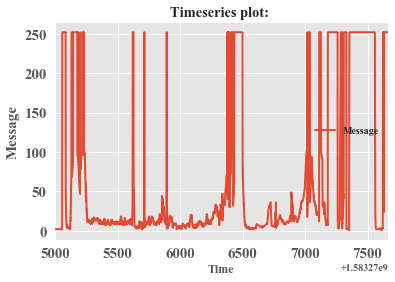

In [6]:
headway = r0.get_ts('DSU_CRUISE', 6)
strym.plt_ts(headway)

Now lets filter above distance to remove all distance that is equal to 252m. A distance of 252m tells that there was no vehicle detected in the front.

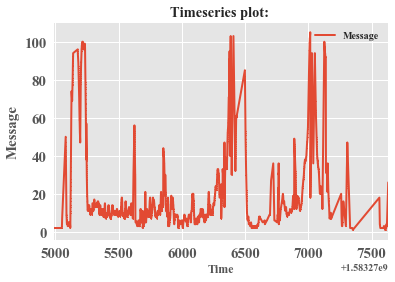

In [7]:
headway_filtered = headway[headway['Message'] < 252]
strym.plt_ts(headway_filtered)

Now we will use `strym`'s inbuilt function `msg_subsebst` to retrieve a subset of original message

## Now lets specify conditions for subsetting.
Subsetting can be done in following ways: specify elpased-time ranges for which you want all messages, specify a list of particular message id or specify conditions. See the documentation for all options.

In [8]:
print(r0.msg_subset.__doc__)


        Get the subset of message dataframe  based on a condition.

        Parameters
        -------------
        
        inplace: `bool`
            Modifies the actual dataframe, if true, otherwise doesn't.


        kwargs: variable list of argument in the dictionary format

            conditions: `str` | `list<str>`
            
                Human readable condition for subsetting of message dataframe.
                Following conditions are available:
            
            - "lead vehicle present": Extracts only those message for which there was lead vehicle present.
            
        
            time: (t0, t1)
                `t0` start elapsed-time
                `t1` end elapsed-time
                
                Extracts messages from time `t0` to `t1`. `t0` and `t1` denotes elapsed-time and not the actual time.
                
            ids: `list`

                Get message dataframe containing messages given the list `id`

          
        Return

There are two ways to get subset of a message. You can either modify original datagrame by passing `inplace=True` to `msg_subset` function or you get a return value as a subset. By default, `inplace=False`. If you don't specify time range, then full dataframe will be used for subsetting. You don't specify a particular message ID, then full dataframe will be used for subsetting.

In [9]:
subset = r0.msg_subset(conditions="lead vehicle present")

In [10]:
subset

,Time,Buffer,Bus,MessageID,Message,MessageLength
Clock,,,,,,
2020-03-03 22:38:01.990089417,1.583275e+09,0000a06c0700e69a000000002fe00000,0,869,000000002fe000,7
2020-03-03 22:38:01.991875887,1.583275e+09,0000e05c0800569e7d04000000000072,0,743,7d04000000000072,8
2020-03-03 22:38:01.992714405,1.583275e+09,000000251600424ef100400008680000,1,296,f10040000868,6
2020-03-03 22:38:01.993907928,1.583275e+09,0000806808003ea2000000000000004f,0,836,000000000000004f,8
2020-03-03 22:38:01.995830536,1.583275e+09,00002032080025a6f2ffe8306464016c,0,401,f2ffe8306464016c,8
...,...,...,...,...,...,...
2020-03-03 23:20:32.456693888,1.583278e+09,0000403318002be87e0a00b0e001702c,1,410,7e0a00b0e001702c,8
2020-03-03 23:20:32.457372189,1.583278e+09,000060331800a6e97e1000b260fee022,1,411,7e1000b260fee022,8
2020-03-03 23:20:32.457628012,1.583278e+09,0000803318001eea7e020000600020a5,1,412,7e020000600020a5,8


Now, to check whether subset has been successful, we will plot ('DSU_CRUISE', 6) and the give plot should give headway distance same as filtered headway distance we saw above. Since `strym`'s function originally require passing csvfile to get the benefit or all utility and plotting functions, we need to manual set dataframe to this subset dataframe as we didn't pass `inplace=True`. In future, we will be able to create `strym` object with a valid CAN dataframe.

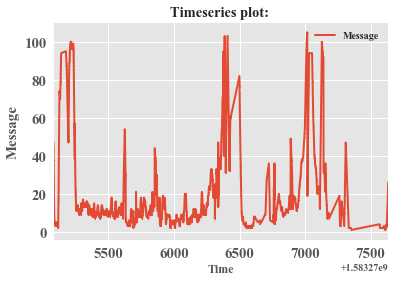

In [11]:
r_new = r0
r_new.dataframe = subset
dsu = r_new.get_ts('DSU_CRUISE', 6)
strym.plt_ts(dsu)

For most part, the last two plots above looks same except for clippings at either ends.

## Get the time slices.
We can also get the time slices satisfying the given condition. It can be done using function `time_subset`. Lets see documentation of this function.

In [12]:
print(r0.time_subset.__doc__)


        Get the time slices satsifying a particular condition for the dataframe.

        Parameters
        -------------
        
        kwargs: variable list of argument in the dictionary format

            conditions: `str` | `list<str>`
            
                Human readable condition for subsetting of message dataframe.
                Following conditions are available:
            
            - "lead vehicle present": Extracts only those message for which there was lead vehicle present.
            
        Returns
        --------
        `list`
            A list of tuples with start and end time of slices. E.g. [(t0, t1), (t2, t3), ...] satisfying the given conditions

        


In [16]:
r0 = strymread(csvlist[0], dbcfile)
time_slices = r0.time_subset(conditions="lead vehicle present")

In [17]:
time_slices.

[[(Timestamp('2020-03-03 22:38:01.990089417'),
   Timestamp('2020-03-03 22:38:47.991396666')),
  (Timestamp('2020-03-03 22:38:52.991271257'),
   Timestamp('2020-03-03 22:39:00.391503572')),
  (Timestamp('2020-03-03 22:39:36.992341280'),
   Timestamp('2020-03-03 22:39:37.592354774')),
  (Timestamp('2020-03-03 22:39:40.592857361'),
   Timestamp('2020-03-03 22:39:56.393051624')),
  (Timestamp('2020-03-03 22:40:00.392931938'),
   Timestamp('2020-03-03 22:40:17.593435049')),
  (Timestamp('2020-03-03 22:40:21.993563175'),
   Timestamp('2020-03-03 22:40:24.993632317')),
  (Timestamp('2020-03-03 22:40:27.593913078'),
   Timestamp('2020-03-03 22:46:57.804323435')),
  (Timestamp('2020-03-03 22:47:05.604496241'),
   Timestamp('2020-03-03 22:48:31.208158493')),
  (Timestamp('2020-03-03 22:48:32.207090139'),
   Timestamp('2020-03-03 22:51:30.012042046')),
  (Timestamp('2020-03-03 22:51:31.611897945'),
   Timestamp('2020-03-03 22:51:31.611897945')),
  (Timestamp('2020-03-03 22:51:32.412163258'),
   

The timeslices cabe used for further analysis.